In [2]:
import os
import gc
import sys
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, GlobalAvgPool2D
from tensorflow.keras import activations, Model, Input
from tensorflow.python.ops.numpy_ops import np_config
from functools import partial
from tqdm import tqdm
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
tf.config.run_functions_eagerly(True)
dataPath = '/scratch/pszyc'
np_config.enable_numpy_behavior()

In [4]:
train_files = [f"{dataPath}/Trainset/out_random_sigma-001-part-{i}.tfrecord" for i in range(5)]
test_files = [f"{dataPath}/Testset/out_random_sigma2k2mm-part-{i}.tfrecord" for i in range(5)]
batch_size = 32
train_dataset = tf.data.TFRecordDataset(train_files, compression_type='GZIP', num_parallel_reads=5)
test_dataset = tf.data.TFRecordDataset(test_files, compression_type='GZIP', num_parallel_reads=5)
# Create a description of the features.
feature_description = {
    'myChargeArray': tf.io.FixedLenFeature([], tf.string),
    'target': tf.io.FixedLenFeature([], tf.string),
}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    charge, target = parsed_features['myChargeArray'], parsed_features['target']
    # decode from bytes
    charge = tf.io.parse_tensor(charge, tf.float64)
    target = tf.io.parse_tensor(target, tf.float64)

    return charge, target


train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.unbatch()
test_dataset = test_dataset.unbatch()

train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

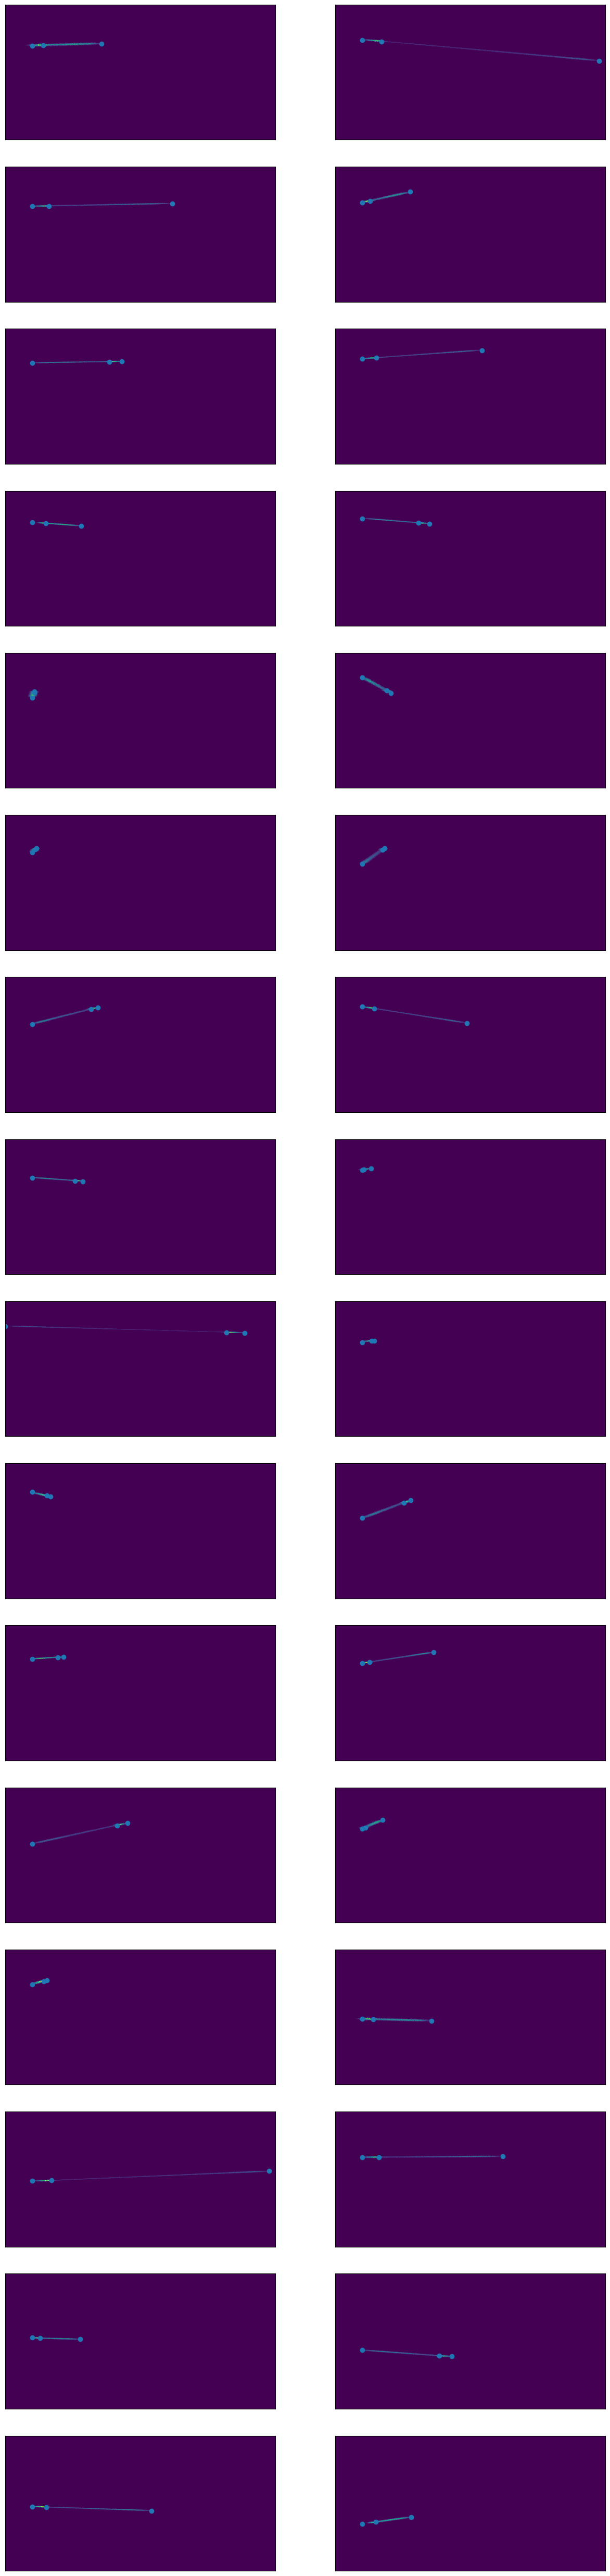

In [5]:
from math import ceil

def view_image(ds):
    image, keypoints = next(iter(ds))
    keypoints = keypoints.reshape(-1, 3, 2)
    batchSize = image.shape[0]
    cols = 2
    rows = ceil(batchSize / cols)

    fig = plt.figure(figsize=(15, rows * 4))
    for idx in range(batchSize):
        ax = fig.add_subplot(rows, cols, idx+1, xticks=[], yticks=[])
        ax.imshow(image[idx, : , :])
        ax.scatter(keypoints[idx, :, 0], keypoints[idx, :, 1])

view_image(train_dataset)

## Create Model

In [6]:
def get_model(output_size = 6):

    img_input = Input(shape = (256,512,1))

    img_rgb = Conv2D(
          filters = 3,
          kernel_size = 1,
          strides = (1,1),
          padding = 'same',
          activation = 'linear',
          kernel_initializer = tf.keras.initializers.Ones()
      )(img_input)

    conv_base = tf.keras.applications.ResNet50(
          include_top = False,
          input_shape = (256,512,3),
          weights = 'imagenet'
      )(img_rgb)

    avg_pool = GlobalAvgPool2D()(conv_base)
    output = Dense(units = output_size)(avg_pool)
    model = Model(inputs = img_input, outputs = output)

    return model

## Train Model

In [7]:
model = get_model()
model.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 512, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 512, 3)       6         
                                                                 
 resnet50 (Functional)       (None, 8, 16, 2048)       23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 6)                 12294     
                                                                 
Total params: 23600012 (90.03 MB)
Trainable params: 23546892 (

In [8]:
model.compile(
    optimizer = 'adam',
    loss = 'mse',
    metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_rmse", patience=50, restore_best_weights=True
)
rlp = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_rmse', factor=0.5, patience=5, min_lr=1e-15, mode='min', verbose=1
)

In [ ]:
model_history = model.fit(
    train_dataset,
    epochs = 3,
    workers = 4,
    validation_data = test_dataset,
    callbacks = [early_stopping]
)

Epoch 1/3
     22/Unknown - 889s 40s/step - loss: 9226.9854 - rmse: 96.0572

In [ ]:
model_history = model_history.history

In [ ]:
plt.plot(model_history['val_rmse'])
plt.plot(model_history['rmse'])
plt.legend(['val_rmse','rmse'])
plt.title("RMSE")